In [125]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [143]:
import numpy as np
import scipy as sp
import sklearn as sk
import cartopy as cp
import xarray as xr
import pandas as pd
import cftime
import dateutil
import dask
#Use the 2 lines below if the notebook has a dark theme (to make labelling visible):
from jupyterthemes import jtplot
jtplot.style(theme='chesterish', context='notebook', ticks=True, grid=False)
import matplotlib.pyplot as plt
#The following code resets the default plot size so you don't have to fiddle with figsize every time"
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 16
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [127]:
#Need the following line to avoid hdf5 issues that prevent opening thee file
# https://stackoverflow.com/questions/49317927/errno-101-netcdf-hdf-error-when-opening-netcdf-file
%env HDF5_USE_FILE_LOCKING=FALSE

env: HDF5_USE_FILE_LOCKING=FALSE


In [128]:
#Load AIRI data 
from netCDF4 import Dataset
from datetime import datetime, timedelta
from netCDF4 import num2date, date2num
dataset_file = "pALLIN.nc"
airi_dat = xr.open_dataset(dataset_file, decode_times=False)
units, reference_date = airi_dat.time.attrs['units'].split('since')
airi_dat['time'] = pd.date_range(start=reference_date, periods=airi_dat.sizes['time'], freq='MS')
#This file's calendar isn't recognized when using xr.open_dataset. The above workaround is from: 
#https://stackoverflow.com/questions/55648630/how-to-decode-the-time-variable-while-using-xarray-to-load-a-netcdf-file
# "M" means "month end frequency" (see https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases)

#### airi_dat

In [129]:
precip = airi_dat['precip']

In [130]:
#Load SLP data
#dataset_file = "data/prmsl.mon.mean.nc"
#dataset_file = "data/20thcenturyslpreanalysis.nc"
slp_dat = xr.open_dataset('/global/scratch/medhap02/prmsl.mon.mean.nc')
#units, reference_date = slp_dat.time.attrs['units'].split('since')
#slp_dat['time'] = pd.date_range(start=reference_date, periods=slp_dat.sizes['time'], freq='MS')
slp = slp_dat['prmsl']

In [131]:
slp_dat

<xarray.Dataset>
Dimensions:    (lat: 181, lon: 360, nbnds: 2, time: 2160)
Coordinates:
  * lat        (lat) float32 -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon        (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * time       (time) datetime64[ns] 1836-01-01 1836-02-01 ... 2015-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    prmsl      (time, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.2
    title:                     Monthly NOAA/CIRES/DOE 20th Century Reanalysis V3
    comments:                  Data are from \nNOAA/CIRES/DOE 20th Century Re...
    standard_name_vocabulary:  NetCDF Climate and Forecast (CF) Metadata Conv...
    license:                   These data are available free of charge under ...
    creator_name:              NOAA/ESRL PSD
    spatial_resolution:        1.0 degree
    platform:                  Model
    institution:               NOAA ESRL Physic

In [132]:
#Slice SLP data to the same duration as precip and calculate monthly anomalies
slp_subset = slp.sel(time=slice('1871-01-30','2017-01-01'))
slp_clim = slp_subset.groupby('time.month').mean('time')
slp_anomfull = slp_subset.groupby("time.month")-slp_clim
slp_anomfull
slp_anom = slp_anomfull.sel(time = slice('1900-01-01', '1988-12-01'))

In [133]:
from cartopy import config
import cartopy.crs as ccrs

from matplotlib import pyplot
import matplotlib.patches as mpatches

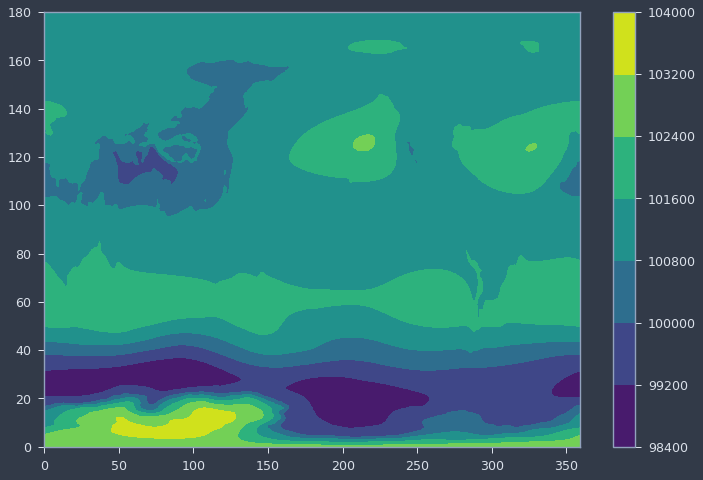

In [134]:
plt.contourf(slp_clim.sel(month=6))
plt.colorbar()

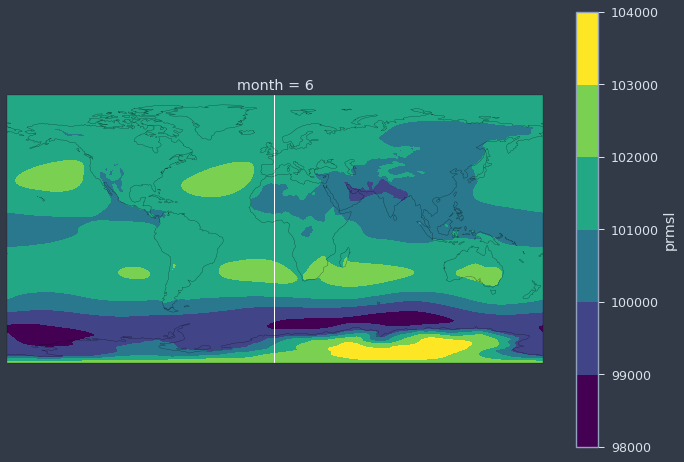

In [135]:
#Test plot of slp_clim

ax = plt.axes(projection=ccrs.PlateCarree())
#plt.contourf(slp_clim.sel(month=6))
slp_clim.sel(month=6).plot.contourf()
ax.coastlines(color='black')
#ax.add_patch(mpatches.Rectangle(xy=[-40,-160], width=30, height=70, facecolor=None, edgecolor='white', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#ax.set_extent([-30,160,0,40],crs=ccrs.PlateCarree(central_longitude=0)); 

#(40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)mega-ENSOpredictorNATMay minus March SLP averaged over(45°N–60°N, 95°E–125°E)Anomalous
    
#plt.colorbar()
#did i do this wrong, not able to see the land masses in black, or do land masses also have slp

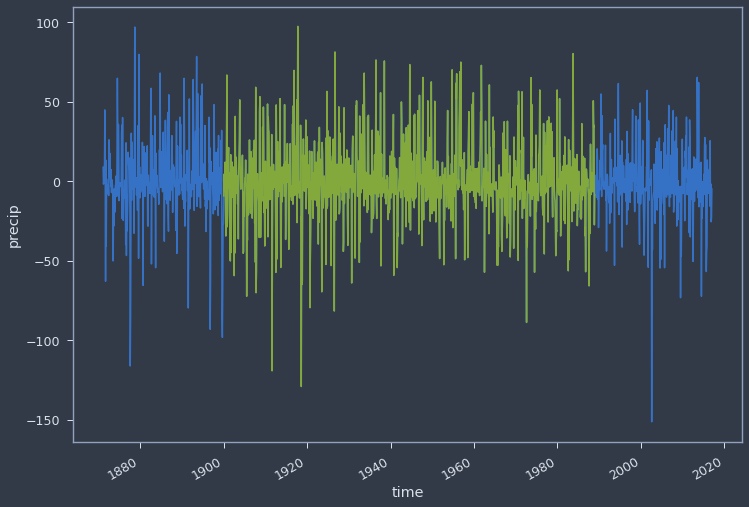

In [136]:
#Get precip anomalies
precip_clim = precip.groupby("time.month").mean("time")
precip_anomfull = precip.groupby("time.month") - precip_clim
precip_anom = precip_anomfull.sel(time = slice('1900-01-01', '1988-12-01'))
precip_anomfull.plot()
precip_anom.plot()

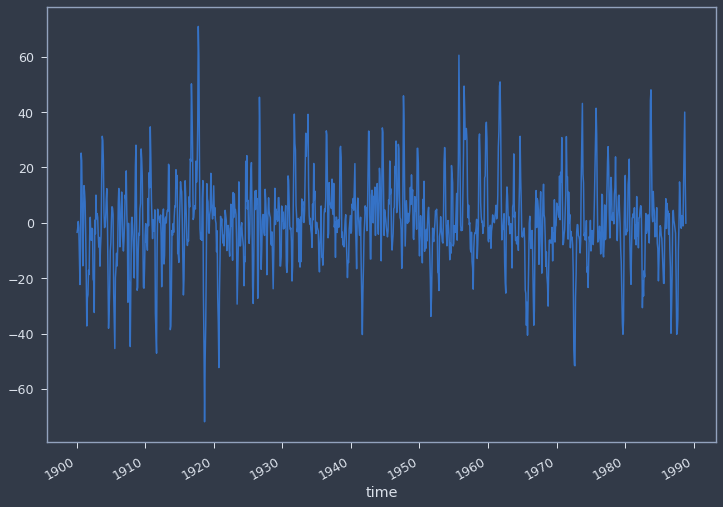

In [137]:
#Seasonal means of precip anomalies
precipa_seasonal = precip_anom.rolling(time=3,center=True).mean()
precipa_seasonal
precipa_seasonal.plot()

In [138]:
#Seasonal means of SLPA
slpa_seasonal = slp_anom.rolling(time=3,center=True).mean()
slpa_seasonal

<xarray.DataArray (time: 1068, lat: 181, lon: 360)>
array([[[        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan],
        ...,
        [        nan,         nan, ...,         nan,         nan],
        [        nan,         nan, ...,         nan,         nan]],

       [[ -40.880207,  -40.880207, ...,  -40.880207,  -40.880207],
        [ -50.164062,  -50.20052 , ...,  -50.036457,  -50.13802 ],
        ...,
        [ 569.32294 ,  568.91406 , ...,  570.1406  ,  569.73956 ],
        [ 569.2214  ,  569.2214  , ...,  569.2214  ,  569.2214  ]],

       ...,

       [[ -64.85156 ,  -64.85156 , ...,  -64.85156 ,  -64.85156 ],
        [-102.36719 , -103.010414, ..., -101.020836, -101.70573 ],
        ...,
        [-667.40625 , -668.21094 , ..., -665.862   , -666.6458  ],
        [-645.02606 , -645.02606 , ..., -645.02606 , -645.02606 ]],

       [[        nan,         nan, ...,         nan,         nan],
        [        na

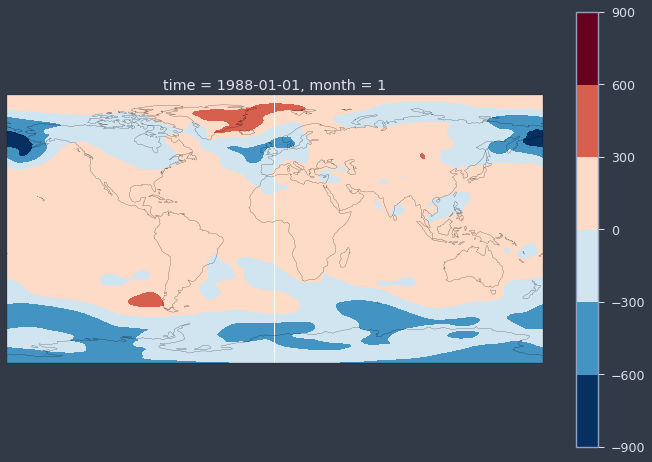

In [139]:
#Test plot of seasonal SLP anomalies in DJF 1997-8
#plt.contourf(slpa_seasonal.sel(time='1998-01-01'))
#plt.colorbar()
ax = plt.axes(projection=ccrs.PlateCarree())
slpa_seasonal.sel(time='1988-01-01').plot.contourf()
ax.coastlines()

In [140]:
#There is no inbuilt xarray correlation function so I used Ryan Abernathey's functions from:
#https://rabernat.github.io/research_computing_2018/xarray-tips-and-tricks.html
#NANs will RUIN EVERYTHING. Drop all leading/trailing NaNs after making a seasonal mean.
def covariance(x, y, dims=None):
    return xr.dot(x - x.mean(dims), y - y.mean(dims), dims=dims) / x.count(dims)

def correlation(x, y, dims=None):
    return covariance(x, y, dims) / (x.std(dims) * y.std(dims))

# correlation starts here

In [141]:
#First, try correlation map with no lag. This should give us r ~= -0.5 in the Tropical Pacific.
x = slpa_seasonal[1:-1,:,:]
y = precipa_seasonal[1:-1]
slp_r = correlation(x, y, dims='time')
#y = slpa_seasonal.sel(lat=0,lon=270)[1:-1]
#dims = 'time'

Text(0.5, 1.0, 'Contemporaneous Correlation Between SLP and AIRI Anomalies (3-month running mean)')

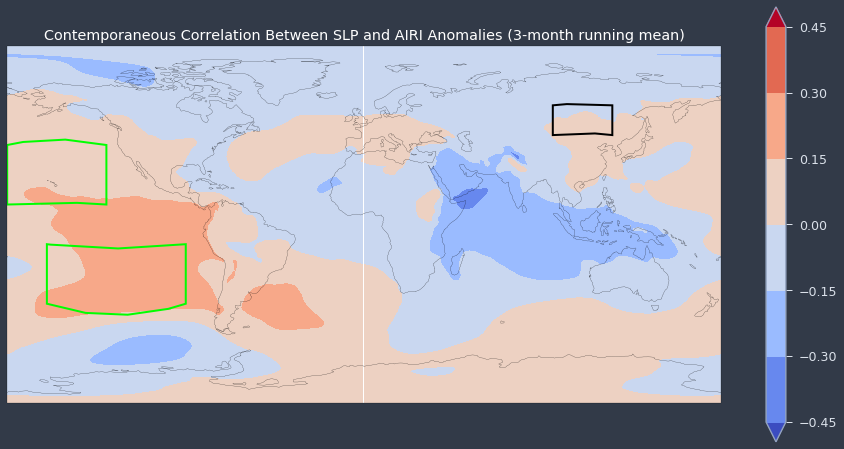

In [166]:
#Plot the result
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Contemporaneous Correlation Between SLP and AIRI Anomalies (3-month running mean)', color = 'white')

In [154]:
#Try the same with only JJA:
julys=np.arange(6,1068,12)
slpa_jja = slpa_seasonal[julys,:,:]
precipa_jja = precipa_seasonal[julys]
slp_jja_r = correlation(slpa_jja,precipa_jja,dims='time')

Text(0.5, 1.0, 'Contemporaneous Correlation Between SLP and AIRI Anomalies (JJA Mean)')

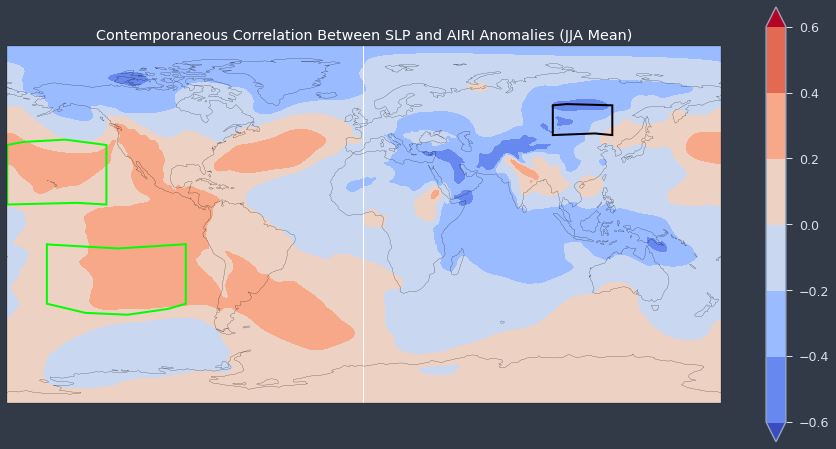

In [167]:
#Plot JJA correlation
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_jja_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_jja_r.plot.contourf(cmap='coolwarm', extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Contemporaneous Correlation Between SLP and AIRI Anomalies (JJA Mean)', color = 'white')

In [172]:
#Try this with a lag of 3 months
slpa_seasonal_3shift = slpa_seasonal.shift(time=-3)
slpa_mam = slpa_seasonal_3shift[julys,:,:]

Text(0.5, 1.0, 'Green: Shifted SLPA (by 3 months)')

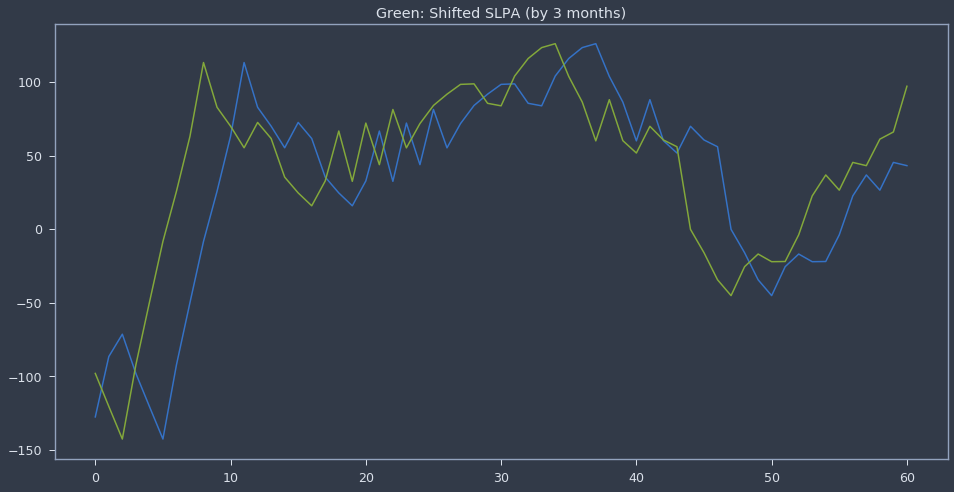

In [173]:
plt.plot(slpa_seasonal.sel(lon=270,lat=0,time=slice('1983-01-01','1988-01-01')))
plt.plot(slpa_seasonal_3shift.sel(lon=270,lat=0,time=slice('1983-01-01','1988-01-01')))
plt.title('Green: Shifted SLPA (by 3 months)')

In [174]:
#Run correlation
slp_mam_r = correlation(slpa_mam,precipa_jja,dims='time')
print(slp_mam_r)

<xarray.DataArray (lat: 181, lon: 360)>
array([[ 0.106499,  0.106499,  0.106499, ...,  0.106499,  0.106499,  0.106499],
       [ 0.111978,  0.112048,  0.112127, ...,  0.111762,  0.111832,  0.111913],
       [ 0.110862,  0.111049,  0.11123 , ...,  0.11029 ,  0.11048 ,  0.110673],
       ...,
       [-0.158102, -0.158412, -0.1587  , ..., -0.157184, -0.157503, -0.157805],
       [-0.149678, -0.149846, -0.150012, ..., -0.149177, -0.149355, -0.149525],
       [-0.141473, -0.141473, -0.141473, ..., -0.141473, -0.141473, -0.141473]])
Coordinates:
  * lat      (lat) float32 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * lon      (lon) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0


Text(0.5, 1.0, 'Correlation Between MAM SLP and JJA AIRI Anomalies')

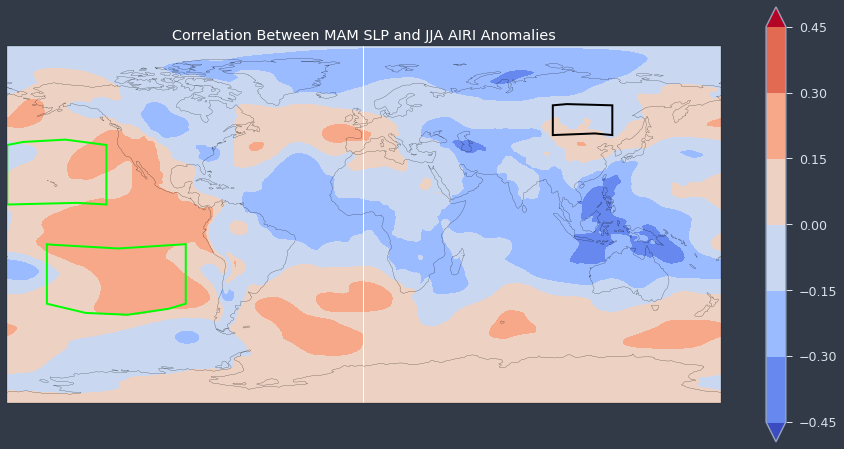

In [176]:
ax = plt.axes(projection=ccrs.PlateCarree())
#lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.colorbar()
slp_mam_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Correlation Between MAM SLP and JJA AIRI Anomalies', color = 'white')

In [177]:
#Try May-March tendency and jjas AIRI to be more consistent with Wang paper
slpa_2shift_dt = slp_anom-slp_anom.shift(time=2) #This has the May minus March value at the May index
precipa_4seasonal = precip_anom.rolling(time=4).mean() #This has the JJAS mean at the Sep index
septembers = np.arange(8,1068,12)
precipa_jjas = precipa_4seasonal[septembers]
slpa_2shift_dt_sep = slpa_2shift_dt.shift(time=4)[septembers,:,:]

In [178]:
slp_may_mar_r = correlation(slpa_2shift_dt_sep,precipa_jjas,dims='time')

Text(0.5, 1.0, 'Correlation Between May-March SLPA and JJAS AIRI Anomalies')

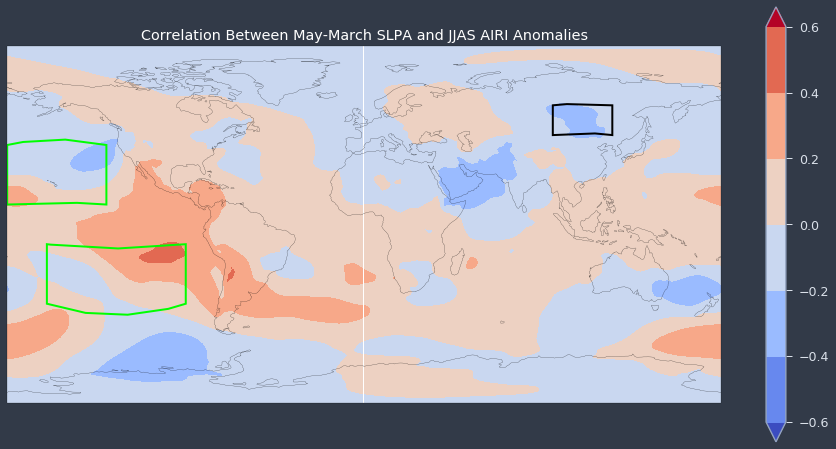

In [180]:
#Plot correlation
ax = plt.axes(projection=ccrs.PlateCarree())
lev = np.linspace(-.5, .5, 11, endpoint=True)
#plt.contourf(slp_may_mar_r,lev,cmap='coolwarm',extend='both')
#plt.colorbar()
slp_may_mar_r.plot.contourf(cmap='coolwarm',extend='both')
ax.coastlines()
ax.add_patch(mpatches.Rectangle(xy=[-160,-40], width=70, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[-180,10], width=50, height=30, facecolor=None, edgecolor='lime', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
ax.add_patch(mpatches.Rectangle(xy=[95,45], width=30, height=15, facecolor=None, edgecolor='black', fill = False, linewidth = 2, transform=ccrs.Geodetic()))
#PSH: April–May mean SLP averaged over SP (40°S–10°S, 160°W–90°W) and NP (10°N–30°N, 180°–130°W)
#NAT: May minus March SLP averaged over(45°N–60°N, 95°E–125°E)
plt.title('Correlation Between May-March SLPA and JJAS AIRI Anomalies', color = 'white')

In [ ]:
# Copyright (c) 2020 Medha Palavalli.